# Characterization of Non-Linearities in the Receiver Frontend

This notebook aims to illustrate non-linear distortion that is common in the analog frontend of transmitters and receivers. The impact of such non-linear effects on signals is demonstrated. Concise summary parameters that capture the essence of a non-linear device are derived and illustrated. 

<a href="https://colab.research.google.com/github/bepepa/digital_comms/blob/master/010_nonlinear_frontend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> (Executable notebook)

<a href="https://nbviewer.org/format/slides/github/bepepa/digital_comms/blob/main/010_nonlinear_frontend.ipynb"><img src="https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg" alt="Render nbviewer" /> </a> (read-only, slides view)

In [1]:
## Boilerplate instructions for importing NumPy and Matplotlib
# Import NumPy
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns_context = "notebook"
sns.set_theme(context=sns_context, style="ticks")

# proper labeling of plots
from matplotlib.ticker import EngFormatter

## Amplifier Non-linearity

Amplifiers and mixers are built from non-linear circuit elements (transistors). Generally, for small signal amplitudes these circuits behave nearly linearly. But as amplitudes increase, the non-linear behavior becomes more apparent. On the flip-side, these circuits operate with better power efficiency when the signal amplitudes are large. The inherent trade-off between linearity and power efficiency is unavoidable. Understanding the impact that non-linearity has on the signals of interest is important to make good decisions about the this trade-off.

A well known model for the non-linearity of a power amplifier is the Saleh model. While Saleh's model describes both amplitude and phase distortion, we limit this discussion to just amplitude distortion. The Saleh model is given by
$$
    y = \frac{\alpha x}{1 + \beta x^2}
$$
where $x$ and $y$ are the input and output voltages, respectively, and $\alpha$ and $\beta$ are model parameters.

The following function  captures the Saleh nonlinear model.

In [2]:
def Saleh(x, alpha=2, beta=1):
    """Saleh model for a non-linear amplifier
    
    Inputs:
    x - input voltage
    alpha - small signal gain (default: 2)
    beta - saturation parameter (default: 1)

    Returns:
    output voltage
    """

    return alpha * x / (1 + beta * x**2)

### Third-Order Approximation

For small input amplitudes, the behavior of the model is approximately linear, i.e., $y \approx \alpha x$. However, for increasing input amplitudes the output deviates from this linear behavior.  

Additionally, the output voltage is maximal when the input voltage equals $x_s = \frac{1}{\sqrt{\beta}}$. The corresponding output voltage is called the saturation voltage and is given by $A_s=\frac{\alpha}{2\sqrt{\beta}}$.

Finally, the Saleh non-linearity can be approximated by a third-order polynomial using a Taylor series expansion. Specifically, the third-order approximation is given by
$$
    y \approx \alpha x - \alpha \beta x^3 = \alpha x \cdot (1- \beta x^2).
$$
This approximation is valid only for reasonably small input amplitudes. However, power amplifiers are usually operated only in regions where the third-order approximation is valid.

We illustrate the non-linearity in the following plot.

In [3]:
# input amplitudes
x = np.linspace(-4, 4, 101) # input amplitude

# model parameters
alpha = 10
beta = 0.1

# compute outputs for Saleh model, ideal amp, and third-order approximation
y = Saleh(x, alpha, beta)
yi = alpha * x
y3 = alpha *  x * (1 - beta * x**2)

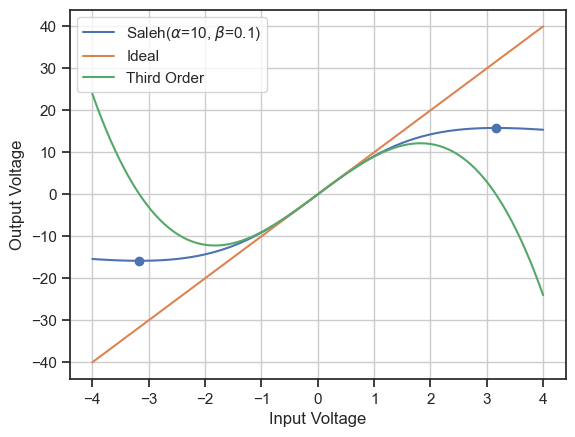

In [4]:
# plots
plt.plot(x, y, x, yi, x, y3)
plt.grid()

plt.xlabel('Input Voltage')
plt.ylabel('Output Voltage')

plt.legend([rf'Saleh($\alpha$={alpha}, $\beta$={beta})', 'Ideal', 'Third Order'])

# plot saturation points of Saleh model
sat = 1/np.sqrt(beta)*np.array([-1, 1])
plt.plot(sat, Saleh(sat, alpha, beta), 'bo')

plt.show()

The plot shows the non-linear relationship between the input and output voltage for the Saleh model. For comparison, an ideal amplifier exhibits a linear, straight-line relationship between input and output voltage. 

Also shown is the third-order approximation to the Saleh model. The third order model tracks the initial deviation of the non-linear model from the ideal, linear behavior. However, it is not accurate for large input amplitudes.

The blue dots mark the saturation amplitudes of the Saleh model. Clearly, the third order model is no longer accurate when the amplifier is saturated. Put differently, this amplifier should be operated well below the saturation point.

### 1dB Compression Point

Instead of focusing on the relationship between the input and output voltages, we are interested in the ratio of the output power to the input power. This ratio is the (power) gain $G$ and it is related to the relationship between input and output voltages $x$ and $y$ through
$$
    G(x) = \frac{y^2(x)}{x^2}.
$$
It is customary to express the gain $G$ in dB, i.e., to specify $10\log_{10}(G)$.

From the description above, we find the 1dB compression point as the input power $x^2$ for which the gain has decreased by 1dB from the ideal, linear power gain $\alpha^2$. Thus, we must find $x$ (or $x^2$) such that
$$
    10\log_{10}\left( \frac{G(x)}{\alpha^2} \right) = 20\log_{10}\left( \frac{y(x)}{\alpha x} \right) = -1 \text{dB} = 20\log_{10}(10^{-1/20})
$$
or, equivalently
$$
    \frac{y(x)}{\alpha x} = 10^{-1/20} = v_{1 \text{dB}}.
$$

For the Saleh model, we find the 1dB compression point, i.e., the input power for which the gain has decreased by 1dB, as
$$
    P_{in,1\text{dB}} = x^2_{1 \text{dB}} = \frac{1-v_{1 \text{dB}}}{v_{1 \text{dB}} \cdot \beta}
$$
and for the third-order approximation $y \approx \alpha x - \alpha \beta x^3$, the 1dB compression point is
$$
P_{in,1\text{dB}} = x^2_{1 \text{dB}} = \frac{1-v_{1 \text{dB}}}{\beta}.
$$

Let's compute and plot the gain for the Saleh model as well as the ideal amplifier and the third-order approximation. 

In [5]:
# Compute and plot power gain
x = np.logspace(-1, 0.3, 100)

G = Saleh(x, alpha, beta)**2 / x**2
G_id = alpha**2
G_3rd = (alpha * (1 - beta * x**2))**2

# 1dB compression point
p1dB = 10**(-1/10)           # linear -1dB power loss
v1dB = np.sqrt(p1dB)         # corresponding amplitude attenuation

p_Saleh = (1-v1dB)/(v1dB*beta) # input power that causes 1dB compression
p_3rd = (1-v1dB)/(beta)        # input power that causes 1dB compression according to 3rd order approximation

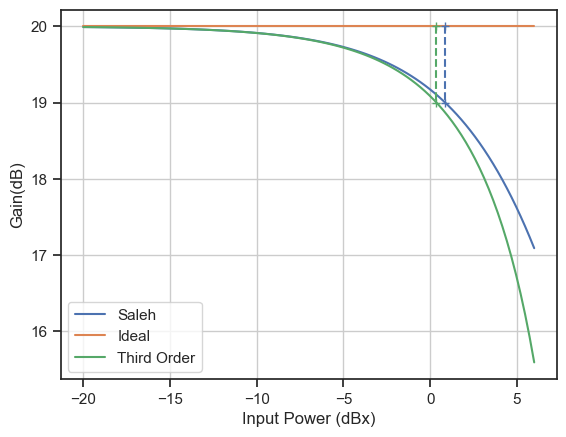

In [6]:
plt.plot(20*np.log10(x), 10*np.log10(G),
20*np.log10(x), 10*np.log10(G_id)*np.ones_like(x),
20*np.log10(x), 10*np.log10(G_3rd))
plt.grid()

plt.xlabel('Input Power (dBx)')
plt.ylabel('Gain(dB)')

plt.legend(['Saleh', 'Ideal', 'Third Order'])

plt.plot(10*np.log10(p_Saleh)*np.ones(2), [20, 19], 'b--+')
plt.plot(10*np.log10(p_3rd)*np.ones(2), [20, 19], 'g--+')

plt.show()

The plot above shows that the gain tracks the gain of the ideal, linear amplifier when the input power is small. However, the gain
decreases as the input power increases. This happens because the amplifier cannot produce arbitrarily large output values as it approaches saturation. 

The 1dB compression point computed from the Saleh model is marked using the blue dashed line; it occurs at an input power of 0.86dBx for the given values of $\alpha$ and $\beta$. 

For comparison, the 1dB compression point computed from the third order approximation is indicated using the green dashed line; it occurs at 0.36dBx. 

In general, the third order approximation is very accurate up to the 1dB compression point.

If an amplifier is operated such that the input power remains well below the 1dB compression point, then the non-linear distortion is generally small and the non-linear distortion is tolerable.

*Note:* The input power is not a dimensionless quantity. Hence, some care must be taken to express it on a dB scale. It is common to express powers with respect to a reference power. For example, if power is measured in Watt (i.e., the reference power is 1W) then we measure that power in terms of dBW on a dB scale. If the reference power is 1mW, the corresponding dB scale is dBm. Moreover, to convert voltage or current amplitudes to powers a resistance $R_s$ is needed. Here, dBx acknowledges that input power needs to be normalized but leaves the exact reference unspecified.

*Note*: We have specified the **Input** 1dB Compression Point. A corresponding 1dB compression point for the **Output** power is $(G-1)\text{dB}$ larger.

#### 1dB Compression Point for a Sinusoidal Signal

The definition that we used for the 1dB compression point is based directly on the gain curve. 

In the literature, it is common to define the 1dB compression point in terms of a sinusoidal input signal of frequency $f_c$ and amplitude $\sqrt{2P_{in}}$. 

When such a sinusoid is passed through a non-linear device harmonic components at multiples of the frequency $f_c$ are generated. 

The exact amplitudes of these harmonics are tedious to compute in general. Moreover, only the fundamental harmonic (at $f_c$) is usually of interest as other, higher  harmonics can be filtered out.

When the non-linearity is approximated by a third-order function, $y(x) \approx a_1 x - a_3 x^3$, then it can be shown that the amplitude of the fundamental harmonic $f_c$ is 
$$
    A(f_c) = a_1 \sqrt{2P_{in}} \cdot (1 - \frac{3 a_3}{2 a_1}P_{in}).
$$ 
For the power of this term to deviate by -1dB from the ideal, linear power, $a_1^2 P_{in}$, the input power  (and, thus, the 1dB compression point) must equal
$$
    P_{in,1 \text{dB}} = \frac{2 a_1}{3 a_3} (1-10^{-1/20}) = \frac{2 a_1}{3 a_3} (1-v_{1 \text{dB}}).
$$

For the Saleh model, $a_1=\alpha$ and $a_3=\alpha \beta$ and, thus,
$$
    P_{in,1 \text{dB}} = \frac{2}{3} \cdot \frac{1-v_{1 \text{dB}}}{\beta}.
$$
This value is $2/3$ of (or 1.7dB lower than) the compression point that we computed directly from the gain curve. This difference is a result of the fact that a sinusoid has a peak-to-average power ratio (PAPR) equal to 2.

*Note:* You may see the 1dB compression point expressed in terms of the square of the amplitude $A^2$ instead of power $P$. To consolidate, recall that for a sinusoidal signal $P=A^2/2$.

#### Third-order Intercept Point IP3

Closely related to the 1dB compression point for sinusoidal signal is the third-order intercept point IP3. The input IP3 (IIP3) is the input power that causes the amplitude at the fundamental harmonic $f_c$ to vanish. Specifically, for the third order approximation IIP3 is the input power $P_{in}$ such that
$$
    A(f_c) = a_1 \sqrt{2P_{in}} \cdot (1 - \frac{3 a_3}{2 a_1}P_{in}) = 0
$$ 
and, therefore, 
$$
    \text{IIP3} = \frac{2 a_1}{3 a_3}.
$$

The output IP3 (OIP3) is the IIP3 (in dB) plus the linear gain ($a_1^2$) also in dB.

Note that the IIP3 and the 1dB compression point differ only by the constant factor $(1-10^{-1/20}) = 0.108 = -9.6\text{dB}$. Thus, for the third-order approximation IIP3 is always 9.6 dB greater than the (input) 1dB compression point.

#### Exercise: Measuring IIP3

IIP3 is difficult to measure with just a single tone. In order to drive $A(f_c)$ to zero, the device has to operate deep in the nonlinear region where the third-order approximation is no longer valid. As an alternative, the following procedure is used in practice to measure IIP3.

*Step 1: Measure the linear gain* For a single tone at frequency $f_1$ the input power $P_{in}$ is varied over a range well below the 1dB compression point and the corresponding output powers $P_{out}$ are measured. For small input powers, we have
$$
    P_{out} = a_1^2 \cdot P_{in},
$$
where $a_1$ is the linear term from the third order approximation.
When output power is plotted over input power on a double logarithmic scale (e.g., both axes in dB), the measurements should form a straight line with slope 1. Why?

*Step 2: Two-tone measurements* A second tone of frequency $f_2$ and the same power $P_{in}$ is added; i.e., the test signal is
$$
    \sqrt{2P} (\cos(2\pi f_1 t) + \cos(2\pi f_2 t)).
$$
When this signals is passed through a third-order non-linearity $y(x) = a_1 x - a_3 x^3$, then there will be signal components at the frequencies $2f_1-f_2$ and $2f_2-f_1$. Show that the amplitude of these components equals
$$
    A(2f_2-f_1) = \sqrt{2P_{in}} \cdot (\frac{3 a_3}{2}P_{in}).
$$
Note that this term appears in the expression for the single-tone amplitude $A(f_c)$. The corresponding output power is
$$
    P_{out}(2f_2-f_1) = \frac{(A(2f_2-f_1))^2}{2} = \left( \frac{3 a_3}{2} \right)^2 P_{in}^3.
$$
When this output power is plotted over the input power on a double logarithmic scale, then measurements should form a straight line wth slope 3. Why?

*Step 3: Extrapolate to find Intercept* When measurements are performed well below the 1dB compression point, the two lines will not intersect. However, when the two straight line segments are extended, i.e., extrapolated to higher power, we can find the input power where the two lines intersect. This point of intersection is the third-order intercept point (IP3). The x-coordinate is IIP3 and the y-coordinate is OIP3.

In the cell below, carry out a numerical simulation to measure IP3 for the Saleh device with $\alpha=10$ and $\beta=0.1$.

In [7]:
# Determine IP3 using two-tone method

### Harmonic Distortion and Intermodulation Products

Non-linear distortion by an amplifier (and/or mixer) causes multiple problems that must be kept to a minimum.

1. **Compression of signal constellations with different power levels:** Consider, for example, a 16-QAM constellation. This constellation consists of signals located on three rings that reflect the magnitude of the symbols in the constellation. The four outermost symbols reuire ten times the power of the four innermost symbols. Therefore, the symbols with large magnitude may experience less gain than the weaker symbols. The result is that the constellation may be distorted so that the distance between points in the constellation is no longer uniform. 

2. **Spectral Broadening:** Non-linear distortion causes the bandwidth of the transmitted signal to increase. This is due to the presence of terms involving powers of the transmitted signal. Since transmitted signals must adhere to stringent emission masks to prevent interference with adjacent channels, this spectral broadening must be avoided.

3. **Intermodulation:** In addition to the signal of interest, the receiver frontend may pick up additional signals, usually out f band from the signal of interest. A non-linear amplifier can cause these signals to interact with each other and produce interfering signal components that fall into the band of the desired signal. This is particularly problematic when the out-of-band interferers are much stronger than the signal of interest.

We will illustrate the second and third problems below.

#### Spectral Broadening

We begin with a complex baseband signal consisting of three tones. With an arbitrarily chosen sample rate $f_s$ of 2MHz and an FFT length of $N=2048$. The tones are placed at

1. Frequency $f_1 = f_s/128$ (15.6KHz) and amplitude $A_1 = 3/\sqrt{14}$
2. Frequency $f_0 = 0$ and amplitude $A_0 = 2/\sqrt{14}$
3. Frequency $f_{-1} = -f_s/128$ (-15.6KHz) and amplitude $A_1{-1}= 1/\sqrt{14}$

The amplitudes are scaled so that the signal has unit power (i.e., 0dBx)

In [8]:
fs = 2e6
W = fs/64
N = 2048

# frequency axis
ff = (np.arange(N) - N//2)*fs/N

#time axis and signal
tt = np.arange(N)/fs
x = 1/np.sqrt(14) * (np.exp(-1j*2*np.pi*W/2*tt) + 2 + 3*np.exp(1j*2*np.pi*W/2*tt))

With this signal, we compute the power spectral density. 

This is simply the squared magnitude of the FFT normalized by the FFT length and the sample rate. 

To make the plot easier to analyze, the axis limits are adjusted to capture the non-zero portions of the spectrum.

In [9]:
# first compute the FFT, scaled by sqrt(N) to make it a unitary transform
XX = np.fft.fftshift(np.fft.fft(x))/np.sqrt(N)

# then take magnitude squared and dived by fs to produce a PSD
PSD = np.abs(XX)**2 / fs

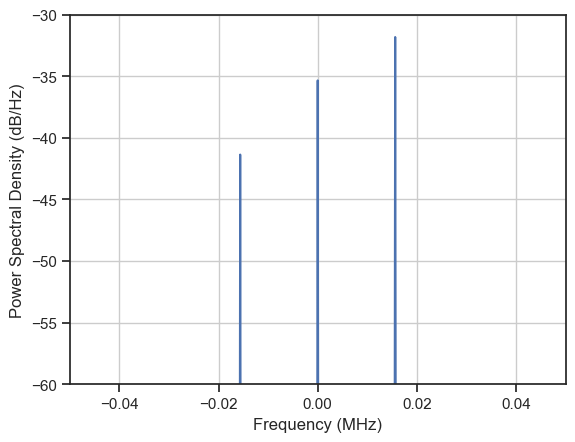

In [10]:
plt.plot(ff/1e6, 10*np.log10(PSD))
plt.grid()

plt.ylim([-60,-30])
plt.xlim([-0.1/2, 0.1/2])

plt.xlabel('Frequency (MHz)')
plt.ylabel('Power Spectral Density (dB/Hz)')

plt.show()

Next, the signal is up-converted to a carrier frequency of $f_c=f_s/4$ (250KHz) to produce the passband signal. Then the PSD of the passband signal is computed.

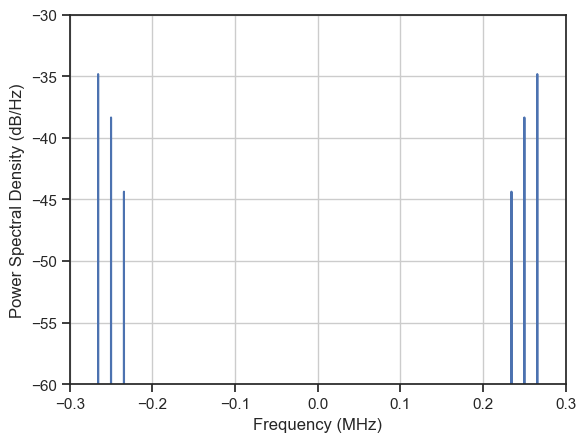

In [11]:
# set the carrier frequency and generate the passband signal
fc = fs/8
xp = np.sqrt(2) * np.real(x * np.exp(2j*np.pi*fc*tt))

# now compute the PSD
Xp = np.fft.fftshift(np.fft.fft(xp))/np.sqrt(N)
PSD_p = np.abs(Xp)**2 / fs

# and plot
plt.plot(ff/1e6, 10*np.log10(PSD_p))
plt.grid()

plt.ylim([-60,-30])
plt.xlim([-0.3, 0.3])

plt.xlabel('Frequency (MHz)')
plt.ylabel('Power Spectral Density (dB/Hz)')

plt.show()

For the actual demonstration, the passband signal is passed through the Saleh non-linearity to model distortion by a non-linear amplifier. 

Recall that the signal was normalized to have unit power, i.e, the input power is 0dB - just below the 1dB compression point. Hence, we should expect some degree of distortion.

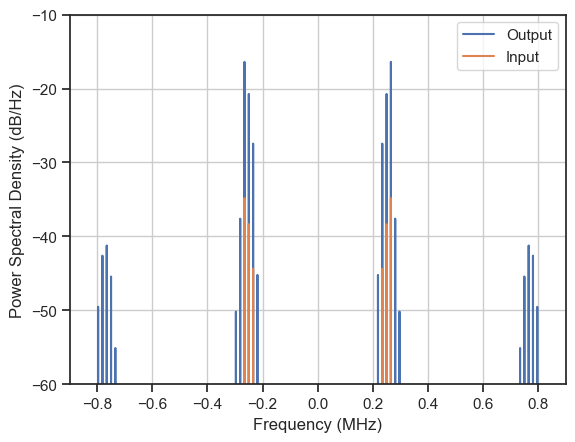

In [12]:
# pass ignal through the non-linear amplifier model
yp = Saleh(xp, alpha, beta)

# then compute the PSD
Yp = np.fft.fftshift(np.fft.fft(yp))/np.sqrt(N)
PSD_yp = np.abs(Yp)**2 / fs

# and plot
plt.plot(ff/1e6, 10*np.log10(PSD_yp))
plt.plot(ff/1e6, 10*np.log10(PSD_p))
plt.grid()

plt.ylim([-60,-10])
plt.xlim([-0.9, 0.9])

plt.xlabel('Frequency (MHz)')
plt.ylabel('Power Spectral Density (dB/Hz)')

plt.legend(['Output', 'Input'])

plt.show()

The plot above shows the input spectrum (in orange) for reference. The blue spectrum is from the output signal. Several observations are immediate.

1. The central portion of the signal spectrum at the carrier frequency (250KHz) shows the amplification by a gain of 20dB. This is the desired effect from the amplifier.
2. The output spectrum at the carrier frequency is broader than the input spectrum. Additional spectral lines appear on both sides of the cluster near the carrier frequency. These additional spectral components may fall outside the emission mask.
3. There are additional spectral clusters at $\pm 3 f_c$ (750KHz). These are results of the non-linear distortion. However, these components are relatively easy to remove with a bandpass filter as they are far from the carrier frequency.

The plot below shows a close-up of the spectrum cluster near the carrier frequency $f_c$. It clearly shows three spectral lines that are not present in the input spectrum.

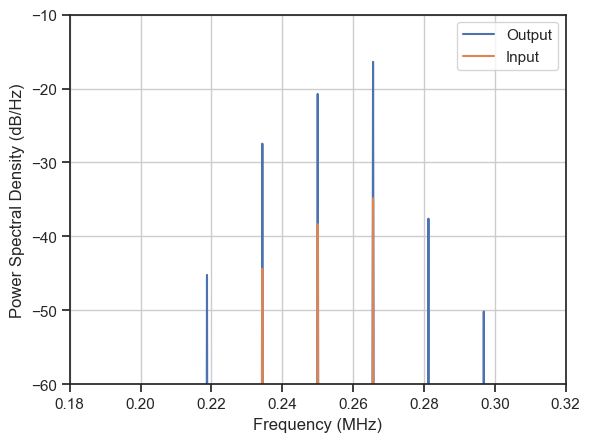

In [13]:
plt.plot(ff/1e6, 10*np.log10(PSD_yp))
plt.plot(ff/1e6, 10*np.log10(PSD_p))
plt.grid()

plt.ylim([-60,-10])
plt.xlim([0.18, 0.32])

plt.xlabel('Frequency (MHz)')
plt.ylabel('Power Spectral Density (dB/Hz)')

plt.legend(['Output', 'Input'])

plt.show()

To mitigate this spectral broadening, we must either reduce the input power - this is called backing off from the 1dB compression point - or we can employ a technique called *pre-distortion*. 

Pre-distortion can be applied to the digital baseband signal. The intent is to shape the signal in such a way that the sequence of pre-distortion and non-linear distortion is a linear function. 

Obviously, we need to know the distortion to do this.

**Exercise: Pre-Distortion** Derive a pre-distortion function $y=f_{PD}(x)$ for the Saleh nonlinearity $f_S(x)$. This predistortion function must be such that 
$$
    f_S(f_{PD}(x)) = \alpha x.
$$

Verify that your pre-distortion works by computing and plotting the power spectral density of the output signal when the three-tone signal is input. It should show no harmonic distortions:

In [14]:
## pre-distortion for Saleh non-linearity

#### Intermodulation

Intermodulation describes the effect that a signal at a frequency different from our frequency of interest has on the signal of interest. **Intermodulation is of concern primarily in the receiver**. 

To be specific, while keeping things tractable, assume that we are interested in receiving a sinusoidal signal of frequency $f_1$ and power $P_1$. The interfering signal is at frequency $f_2$ and has power $P_2$. Thus, the signal entering our non-linear device has the form
$$
x(t) = \sqrt{2P_1} \cos(2\pi f_1 t) + \sqrt{2P_2} \cos(2\pi f_2 t).
$$

We begin by simulating what happens when $x(t)$ passes through the Saleh non-linearity. In this experiment we set $P_1=0.1=-10\text{dBx}$ and $P_2=1=0\text{dBx}$ so that we should be operating near the 1dB compresion point.

In [15]:
fs = 2e6
N = 2048

# frequency axis
ff = (np.arange(N) - N//2)*fs/N

f1 = fs/2048*61
f2 = fs/2048*293
P1 = 0.1
P2 = 1

#time axis and signal
tt = np.arange(N)/fs
x = np.sqrt(2*P1)*np.cos(2*np.pi*f1*tt) + np.sqrt(2*P2)*np.cos(2*np.pi*f2*tt)

# apply the Saleh non-linearity
y = Saleh(x, alpha, beta)

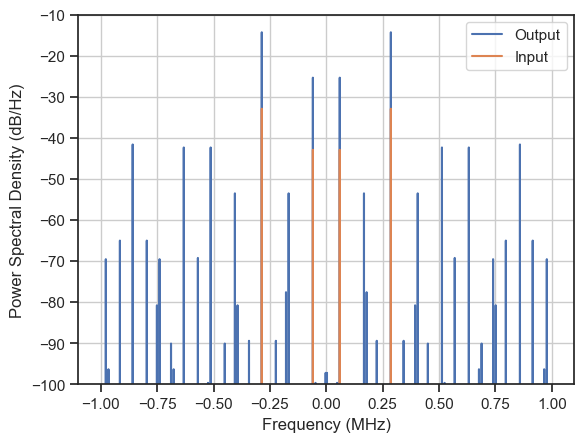

In [16]:
# now compute the PSDs
X = np.fft.fftshift(np.fft.fft(x))/np.sqrt(N)
PSD_x = np.abs(X)**2 / fs

Y= np.fft.fftshift(np.fft.fft(y))/np.sqrt(N)
PSD_y = np.abs(Y)**2 / fs

# and plot
plt.plot(ff/1e6, 10*np.log10(PSD_y))
plt.plot(ff/1e6, 10*np.log10(PSD_x))

plt.grid()

plt.ylim([-100,-10])

plt.xlabel('Frequency (MHz)')
plt.ylabel('Power Spectral Density (dB/Hz)')
plt.legend(['Output', 'Input'])

plt.show()

The spectrum plot above shows a very large number of frequencies that arise from the non-linear interaction between the two input frequencies (in orange). 

These components are called intermodulation (IM) products. In contrast to the single tone (or narrowband signal) case considered above, the spectrum does not show merely harmonics (i.e., multiples of the original frequencies) but also components at frequencies of the form $\pm m f_1 \pm n f_2$ for all combinations of $m$ and $n$.

If our signal of interest is at frequency $f_1$, we can compute the amplitude at that frequency for the third-order approximation $y(x) \approx a_1 x - a_3 x^3$,
$$
A(f_c) = a_1 \sqrt{2P_{1}} \cdot (1 - \frac{3 a_3}{2 a_1}(P_{1} + 2P_2)).
$$
The presence of the interfering signals power, $P_2$, indicates that the intermodulation causes the out-of-band interference to appear in the band of interest. This is very problematic when the interfering signal is much stronger than the signal of interest as it leads to additional gain compression.

To illustrate this problem, we compute again the gain that our signal of interest experiences for different values of the interfering signal's power $P_2$.

In [17]:
# Saleh parameters
alpha = 10
beta = 0.1

# signal parameters
fs = 2e6
f1 = fs/2048*61
f2 = fs/2048*293
P1 = np.logspace(-2, 0.2, 20)
P2 = np.array([0.01, 0.1, 0.3, 0.5, 0.8])

cos1 = np.cos(2*np.pi*f1*tt)
cos2 = np.cos(2*np.pi*f2*tt)

# storage for results
G_saleh = np.zeros((len(P2), len(P1)))
G_3rd = np.zeros_like(G_saleh)

for n in range(len(P2)):
    this_P2 = P2[n]

    for m in range(len(P1)):
        this_P1 = P1[m]

        # pass a signal through the non-linearity, then pull out amplitude at f1
        x = np.sqrt(2*this_P1) * cos1 + np.sqrt(2*this_P2) * cos2
        y = Saleh(x, alpha, beta)
        Afc = 2 * np.mean(y*cos1)
        G_saleh[n, m] = Afc**2/(2*this_P1)

        G_3rd[n, m] = alpha**2 *(1 - 1.5*beta*(this_P1 + 2*this_P2))

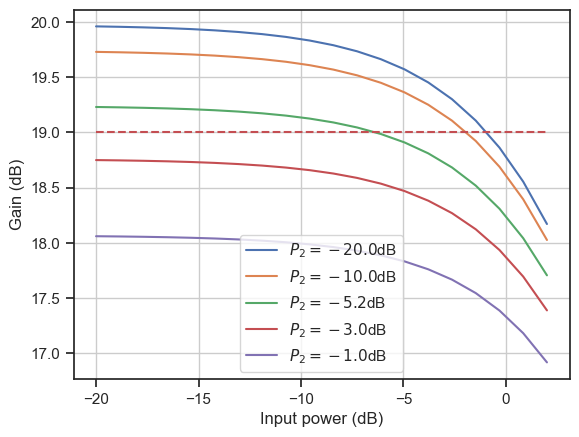

In [18]:
# plt.plot(10*np.log10(P1), 10*np.log10(G_3rd.T))
plt.plot(10*np.log10(P1), 10*np.log10(G_saleh.T))
plt.plot(10*np.log10(P1), 19*np.ones_like(P1), 'r--')

plt.grid()
plt.xlabel('Input power (dB)')
plt.ylabel('Gain (dB)')

plt.legend(['$P_2 = {:4.1f}$dB'.format(10*np.log10(p2)) for p2 in P2])

plt.show()

Clearly, the presence of the interfering signal leads to further gain compression - even though that signal is out of band. When $P_2$ is greater than -3dB, it is not even possible for the signal of interest to achieve 19dB of gain. Strong out-of-band interference is often called a *blocker*. 

When signals are modulated - not just tones - the problem gets worse since the the interfering signal mixes with the signal of interest and produces in-band interference that has an effect similar to noise. 

The main mitigation against this problem is strong passband filtering before the first amplifier or mixer.

## Summary

This notebook has focused on the detrimental impact that non-linearities in the analog frontend have on the transmitted and received signals. Techniques for analyzing these effects were discussed, including polynomial approximation and simulation.

The importance and significance of summary parameters 1dB compression point and IP3 were discussed. It was demonstrated that non-linear effects are modest as long as the total power is well below the 1dB compression point.